<a href="https://colab.research.google.com/github/hellocybernetics/TensorFlow_Eager_Execution_Tutorials/blob/master/tutorials/99_others/dropout_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats

%matplotlib inline
sns.set()

In [0]:
tf.enable_eager_execution()

In [0]:
tfe = tf.contrib.eager
tfd = tfp.distributions
ed = tfp.edward2

L = tf.keras.layers
F = tf.nn

## データ
今回は実験用データとして下記のデータを人工的に生成する。

$$
y = 0.5 \sqrt x + sin(3x) + \epsilon
$$

$\epsilon$ は正規分布からさせたノイズで標準偏差を $0.3$ に加工してある。

データ点は区間 $[0, 1)$ に対しては5個、$[1, 2)$ に対しては10個、 $[2, 3)$ に対しては3個だけ観測できているとする。ベイズの効力を見るためには、このように少ないデータ点での振る舞いを見たほうが面白い。

In [0]:
def toy_data():
    x1 = np.random.rand(5)
    x2 = 1 + np.random.rand(10)
    x3 = 2 + np.random.rand(3)
        
    num_of_sample = x1.shape[0] + x2.shape[0] + x3.shape[0]
    
    x = np.hstack([x1, x2, x3])

    y = 0.5*np.sqrt(x) + np.sin(3*x) + 0.3*np.random.randn(num_of_sample)
    return x.reshape(-1, 1), y.reshape(-1, 1)

x_train, y_train = toy_data()

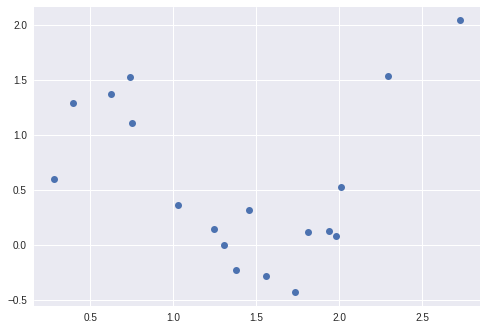

In [144]:
plt.plot(x_train, y_train, "o")

## モデル
今回は簡単に実装できるドロップアウトを用いたベイズニューラルネットを作成する。パラメータを有する層全てに対してドロップアウトを適用する。順番としては、

1. パラメータを用いた変換
2. ドロップアウト
3. 活性化関数適用

という形になる。ドロップアウトと言えばとある層の特徴量を $0$ にして表現力を意図的に低下させる手法であるが、これをパラメータが確率的にサンプリングされたことによって、ある特徴量が $0$ になったとみなすことが肝である（そのような論理展開を行うために、パラメータを持つ層全てにドロップアウトを適用するのである）。

In [0]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=[1]),
    L.Dense(32),
    L.Dropout(0.3),
    L.ReLU(),
    L.Dense(32),
    L.Dropout(0.3),
    L.ReLU(),
    L.Dense(32),
    L.Dropout(0.3),
    L.ReLU(),
    L.Dense(1),
])

In [155]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 32)                64        
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                1056      
__________

## 学習
学習は従来通り勾配法（を弄くったAdam）を用いる。ベイズ推論になることは、モデルの構成の方で担保しているので学習は特に触る必要がない。

In [0]:
loss_fn = lambda y, y_pre: tf.reduce_mean((y - y_pre)**2)
optimizer = tf.train.AdamOptimizer()

@tfe.defun
def train(x, y):
    
    with tf.GradientTape() as g:
        y_pre = model(x, training=True)
        loss = loss_fn(y, y_pre)
    grads = g.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    
    return loss, y_pre

In [157]:
x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)


loss_list = []
y_pre_list = []
for epoch in range(10000):
    
    loss, y_pre = train(x_train_tensor, y_train_tensor)
    
    if (epoch + 1) % 10 == 0:
        loss_list.append(loss.numpy())
        y_pre_list.append(y_pre.numpy())
    
    if (epoch + 1) % 1000 == 0:
        print("loss {}: {:0.3f}".format(epoch+1, loss.numpy()))

loss 1000: 0.308
loss 2000: 0.213
loss 3000: 0.166
loss 4000: 0.096
loss 5000: 0.095
loss 6000: 0.132
loss 7000: 0.161
loss 8000: 0.062
loss 9000: 0.085
loss 10000: 0.301


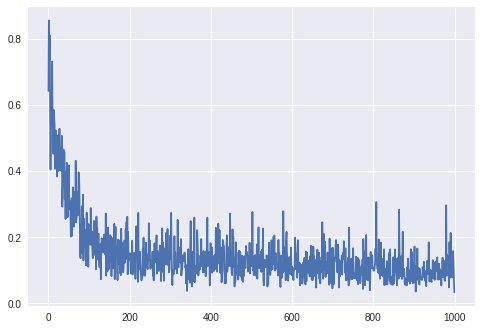

In [149]:
plt.plot(loss_list)

## 学習結果
赤が観測データ、青が学習最終段階のモデルからのサンプリングデータ、緑が学習初期段階のモデルのサンプリングデータである。学習が進んで観測データに近い分布を獲得していった雰囲気が見られる。

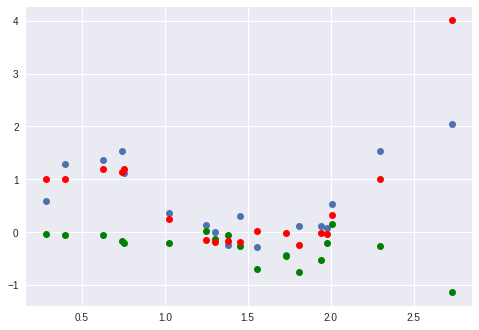

In [159]:
plt.plot(x_train, y_train, 'o')
plt.plot(x_train, y_pre_list[0], 'og')
plt.plot(x_train, y_pre_list[-1], 'or')

### ベイズ予測区間
上記は定性的に学習が進んだことを確認する程度の話であった。ここからはベイズ予測区間を見る。今回観測データ$D =  (x_i, f(x_i)) $ の定義域は $[0, 3)$ であった。下記ではベイズ予測区間を見るために、 $[-0.5, 3.5]$ の区間の入力を与えて見ることにする（当然、一切観測されていない区間に関してはベイズ予測区間が広がるはずである）。

ベイズ予測区間は下記の式である。

$$
p(y | x) = \int_w p(y|w, x)p(w|D)dw
$$

この積分を計算するのは通常は困難であるため、今回は下記のように近似する。

$$
p(y|x) \simeq \frac{1}{K}\sum_{k=1}^{K} p(y | w_k , x)  
$$

ここで $K$ はパラメータをサンプリングする回数である。ここでパラメータのサンプリングとは「ドロップアウトを反映すること」である。先に述べた通り、ドロップアウトを反映することによって「ある特徴量が $0$ になるようなパラメータのサンプリングを行った」ということにできる。下記コードでは $K = 100$ とした（すなわち 各 $x_i$ に対して予測値 $y_i $が $100$ 個 作られることになる。このヒストグラムを書くことで予測分布を描ける）。

In [0]:
def bayes_predict_dist(num_samples=100):
    x = tf.reshape(tf.range(-0.5, 3.5, 0.01), [-1, 1])
    sample_list = []
    
    for _ in range(num_samples):
        sample_list.append(model(x, training=True))
        
    samples = tf.stack(sample_list, axis=0)

    return tf.squeeze(x), tf.squeeze(samples) 

### 回帰
ベイズ予測分布を使って予測を行う場合は、予測分布 $p(y | x)$ の期待値を使うが、実用上はサンプル平均を使う場合が多い。今回の場合は 1つの$x_i$ に対して $y_i$ が100個生成されている。その各々の &y_i& に関して平均をサンプルを取っていき回帰線を作ることとする。また、作った回帰線の周りに50%ベイズ予測区間と95%ベイズ予測区間を描く（A%ベイズ予測区間とはモデルによる予測値がA%の確率でその範囲に収まるような区間である）。

モデルに用いたデータが少ないような場所ではベイズ予測区間は広がる（予測に確信を持たないため）。今回の場合は特にデータ点が著しく少ない $x>2$ 以降で予測区間が大きく広がっているのが分かる。

In [0]:
index_point, samples = bayes_predict_dist()
mean = tf.reduce_mean(samples, axis=0).numpy()

df = pd.DataFrame(samples.numpy())

low_y50, high_y50 = stats.mstats.mquantiles(df, [0.25, 0.75], axis=0)
low_y95, high_y95 = stats.mstats.mquantiles(df, [0.025, 0.975], axis=0)

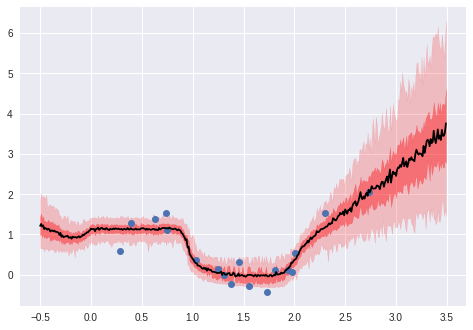

In [164]:
plt.plot(x_train, y_train, "o")
plt.plot(index_point, mean, "black")
plt.fill_between(index_point, low_y50, high_y50, alpha=0.4, color="r")
plt.fill_between(index_point, low_y95, high_y95, alpha=0.2, color="r")